# ETL (Part 1) Loading the survey raw data into a database using SQLite

In [1]:
# Import dependencies
import pandas as pd
import sqlite3
from tabulate import tabulate 
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
from collections import Counter
from wordcloud import STOPWORDS
import re

In [2]:
# Define the path to the CSV file
survey_raw_data = 'data/survey.csv'

In [3]:
# Load the CSV data into a DataFrame
survey_raw_df = pd.read_csv(survey_raw_data)

## Cleanup the columns

### Clean up column[Gender]

In [4]:
survey_raw_df['Gender'] = survey_raw_df['Gender'].str.strip()
survey_raw_df['Gender'] = survey_raw_df['Gender'].str.lower()

male_variations = ['male', 'm', 'maile', 'cis male', 'mal', 'male (cis)', 'make', 'man', 'msle', 'mail', 'malr', 'cis man']
female_variations = ['female', 'f', 'cis female', 'woman', 'femake', 'female (cis)', 'femail']

for male_variation in male_variations:
    survey_raw_df['Gender'] = survey_raw_df['Gender'].replace(male_variation, 'M')

for female_variation in female_variations:
    survey_raw_df['Gender'] = survey_raw_df['Gender'].replace(female_variation, 'F')


### Determine remaining values in Gender column

In [5]:
remaining = survey_raw_df[survey_raw_df['Gender'] != 'M']
remaining = remaining[remaining['Gender'] != 'F']

print(remaining['Gender'].count())
remaining.head(50)

14


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
72,2014-08-27 11:54:27,23,trans-female,United States,MA,No,No,No,Rarely,More than 1000,...,Somewhat difficult,Maybe,No,Yes,Yes,No,No,No,No,NaN
306,2014-08-27 14:22:36,30,queer,United States,IL,No,Yes,Yes,Rarely,26-100,...,Somewhat easy,Maybe,No,Some of them,Yes,No,No,Don't know,No,NaN
349,2014-08-27 14:47:28,25,non-binary,United States,CA,No,Yes,Yes,Sometimes,More than 1000,...,Don't know,Maybe,No,Some of them,Some of them,No,No,Yes,No,NaN
387,2014-08-27 15:24:22,29,non-binary,United States,CA,Yes,Yes,Yes,Sometimes,1-5,...,Very difficult,Yes,No,Some of them,No,No,Maybe,No,No,NaN
412,2014-08-27 15:30:51,31,non-binary,United Kingdom,NaN,No,Yes,Yes,Sometimes,More than 1000,...,Don't know,Yes,Maybe,No,No,No,Yes,Yes,No,NaN
415,2014-08-27 15:31:20,30,non-binary,Germany,NaN,No,Yes,Yes,Sometimes,100-500,...,Somewhat difficult,No,No,Yes,Yes,Maybe,Maybe,No,No,In Germany your employer doesn't really provid...
450,2014-08-27 15:53:59,40,queer,United States,VA,No,Yes,No,Never,More than 1000,...,Don't know,Yes,Maybe,No,Some of them,No,Maybe,Yes,No,NaN
543,2014-08-27 18:13:38,28,non-binary,United Kingdom,NaN,No,Yes,Yes,Rarely,100-500,...,Somewhat difficult,Yes,Yes,Some of them,Some of them,Yes,No,No,Yes,I bring up my depression in interviews solely ...
552,2014-08-27 18:56:46,21,non-binary,United Kingdom,NaN,No,No,Yes,Sometimes,26-100,...,Somewhat easy,Maybe,No,Some of them,Some of them,No,No,Yes,No,NaN
681,2014-08-28 09:02:16,19,trans-female,United States,MO,No,Yes,Yes,Often,26-100,...,Somewhat difficult,Maybe,Maybe,No,No,No,Maybe,No,No,NaN


### Abbreviate genders

In [6]:
gender_abbreviations = {
    "trans-female"  : "TF",
    "trans-male"    : "TM",
    "queer"         : "Q",
    "non-binary"    : "NB"
}

for gender_name, gender_abbreviation in gender_abbreviations.items():
    survey_raw_df['Gender'] = survey_raw_df['Gender'].replace(gender_name, gender_abbreviation)

survey_raw_df.head()


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,F,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,M,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,M,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,M,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


### Verify data in Gender columns are correctly abbreviated

In [7]:
remaining = survey_raw_df[survey_raw_df['Gender'] != 'M']
remaining = remaining[remaining['Gender'] != 'F']

print(remaining['Gender'].count())
remaining.head(20)

14


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
72,2014-08-27 11:54:27,23,TF,United States,MA,No,No,No,Rarely,More than 1000,...,Somewhat difficult,Maybe,No,Yes,Yes,No,No,No,No,NaN
306,2014-08-27 14:22:36,30,Q,United States,IL,No,Yes,Yes,Rarely,26-100,...,Somewhat easy,Maybe,No,Some of them,Yes,No,No,Don't know,No,NaN
349,2014-08-27 14:47:28,25,NB,United States,CA,No,Yes,Yes,Sometimes,More than 1000,...,Don't know,Maybe,No,Some of them,Some of them,No,No,Yes,No,NaN
387,2014-08-27 15:24:22,29,NB,United States,CA,Yes,Yes,Yes,Sometimes,1-5,...,Very difficult,Yes,No,Some of them,No,No,Maybe,No,No,NaN
412,2014-08-27 15:30:51,31,NB,United Kingdom,NaN,No,Yes,Yes,Sometimes,More than 1000,...,Don't know,Yes,Maybe,No,No,No,Yes,Yes,No,NaN
415,2014-08-27 15:31:20,30,NB,Germany,NaN,No,Yes,Yes,Sometimes,100-500,...,Somewhat difficult,No,No,Yes,Yes,Maybe,Maybe,No,No,In Germany your employer doesn't really provid...
450,2014-08-27 15:53:59,40,Q,United States,VA,No,Yes,No,Never,More than 1000,...,Don't know,Yes,Maybe,No,Some of them,No,Maybe,Yes,No,NaN
543,2014-08-27 18:13:38,28,NB,United Kingdom,NaN,No,Yes,Yes,Rarely,100-500,...,Somewhat difficult,Yes,Yes,Some of them,Some of them,Yes,No,No,Yes,I bring up my depression in interviews solely ...
552,2014-08-27 18:56:46,21,NB,United Kingdom,NaN,No,No,Yes,Sometimes,26-100,...,Somewhat easy,Maybe,No,Some of them,Some of them,No,No,Yes,No,NaN
681,2014-08-28 09:02:16,19,TF,United States,MO,No,Yes,Yes,Often,26-100,...,Somewhat difficult,Maybe,Maybe,No,No,No,Maybe,No,No,NaN


### Filter Column['Age']

In [8]:
min_age = 0
max_age = 120
survey_raw_df = survey_raw_df[(survey_raw_df['Age'] >= min_age) & (survey_raw_df['Age'] <= max_age)]

### Clean up timestamp
1. Rename Timestamp to survey_date
2. Remove time - just keep date

In [9]:
survey_raw_df = survey_raw_df.rename(columns={'Timestamp': 'survey_date'})
survey_raw_df['survey_date'] = pd.to_datetime(survey_raw_df['survey_date']).dt.date
survey_raw_df.head()

,survey_date,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27,37,F,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27,32,M,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27,31,M,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27,31,M,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


### Create company size column

In [10]:
survey_raw_df['company_size'] = survey_raw_df['no_employees']
size_names = {
    "1-5"               : "Very Small",
    "6-25"              : "Small",
    "26-100"            : "Medium",
    "100-500"           : "Large",
    "500-1000"          : "Very Large",
    "More than 1000"    : "Mega"
}

for no_of_employees, size_name in size_names.items():
    survey_raw_df['company_size'] = survey_raw_df['company_size'].replace(no_of_employees, size_name)

survey_raw_df.head()

,survey_date,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments,company_size
0,2014-08-27,37,F,United States,IL,NaN,No,Yes,Often,6-25,...,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN,Small
1,2014-08-27,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Maybe,No,No,No,No,No,Don't know,No,NaN,Mega
2,2014-08-27,32,M,Canada,NaN,NaN,No,No,Rarely,6-25,...,No,No,Yes,Yes,Yes,Yes,No,No,NaN,Small
3,2014-08-27,31,M,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN,Medium
4,2014-08-27,31,M,United States,TX,NaN,No,No,Never,100-500,...,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN,Large


## Test if research question can now be answered

In [11]:
survey_data_tech_workers = survey_raw_df[survey_raw_df['tech_company'] == 'Yes']
num_of_tech_workers = len(survey_data_tech_workers)

num_tw_with_mh_issues = survey_data_tech_workers[survey_data_tech_workers['mental_health_consequence'] == 'Yes']
num_tw_with_mh_issues = len(num_tw_with_mh_issues)

percentage_with_issues = float(num_tw_with_mh_issues) / float(num_of_tech_workers) * 100
percentage_with_issues = round(percentage_with_issues, 2)
percentage_with_issues

21.62

In [12]:
survey_data_df = survey_raw_df.copy()
survey_data_df.head()

,survey_date,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments,company_size
0,2014-08-27,37,F,United States,IL,NaN,No,Yes,Often,6-25,...,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN,Small
1,2014-08-27,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Maybe,No,No,No,No,No,Don't know,No,NaN,Mega
2,2014-08-27,32,M,Canada,NaN,NaN,No,No,Rarely,6-25,...,No,No,Yes,Yes,Yes,Yes,No,No,NaN,Small
3,2014-08-27,31,M,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN,Medium
4,2014-08-27,31,M,United States,TX,NaN,No,No,Never,100-500,...,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN,Large


## Write to the Database

### Create connection to SQLITE database

In [13]:
# Create a connection to the SQLite database
conn = sqlite3.connect('survey_database.db')
cursor = conn.cursor()

In [14]:
# Define the table name
table_name = "survey_data"

In [15]:
# Create the table in SQLite (replace it if it already exists)
survey_data_df.to_sql(table_name, conn, if_exists='replace', index=False)

1253

In [16]:
# Commit the changes
conn.commit()

In [17]:
# Verify that the data was loaded by querying the table
query = f"SELECT survey_date, Age, Gender, company_size, seek_help, mental_health_consequence FROM survey_data WHERE tech_company = 'Yes';"
result = pd.read_sql_query(query, conn)
result.head()

,survey_date,Age,Gender,company_size,seek_help,mental_health_consequence
0,2014-08-27,37,F,Small,Yes,No
1,2014-08-27,32,M,Small,No,No
2,2014-08-27,31,M,Medium,No,Yes
3,2014-08-27,31,M,Large,Don't know,No
4,2014-08-27,33,M,Small,Don't know,No


In [18]:
# Close the connection
conn.close()

In [19]:
print(tabulate(result, headers='keys', tablefmt='psql'))

+------+---------------+-------+----------+----------------+-------------+-----------------------------+
|      | survey_date   |   Age | Gender   | company_size   | seek_help   | mental_health_consequence   |
|------+---------------+-------+----------+----------------+-------------+-----------------------------|
|    0 | 2014-08-27    |    37 | F        | Small          | Yes         | No                          |
|    1 | 2014-08-27    |    32 | M        | Small          | No          | No                          |
|    2 | 2014-08-27    |    31 | M        | Medium         | No          | Yes                         |
|    3 | 2014-08-27    |    31 | M        | Large          | Don't know  | No                          |
|    4 | 2014-08-27    |    33 | M        | Small          | Don't know  | No                          |
|    5 | 2014-08-27    |    35 | F        | Very Small     | No          | Maybe                       |
|    6 | 2014-08-27    |    39 | M        | Very Small 

In [20]:
# Connect to the database 
conn = sqlite3.connect('survey_database.db')

In [21]:
# Load data into a DataFrame
query = "SELECT * FROM survey_data;"
df = pd.read_sql_query(query, conn)

In [22]:
# Filter data to only include respondents from the United States and select relevant columns
usa_data = df[df['Country'] == 'United States'][[
   'Age', 'benefits', 'leave', 'mental_health_consequence', 'phys_health_consequence',
    'company_size', 'remote_work', 'work_interfere', 'comments'
]]

usa_data.head(10)

,Age,benefits,leave,mental_health_consequence,phys_health_consequence,company_size,remote_work,work_interfere,comments
0,37,Yes,Somewhat easy,No,No,Small,No,Often,None
1,44,Don't know,Don't know,Maybe,No,Mega,No,Rarely,None
4,31,Yes,Don't know,No,No,Large,Yes,Never,None
5,33,Yes,Don't know,No,No,Small,No,Sometimes,None
6,35,No,Somewhat difficult,Maybe,Maybe,Very Small,Yes,Sometimes,None
8,42,Yes,Very difficult,Maybe,No,Large,No,Sometimes,None
10,31,Don't know,Don't know,No,No,Small,Yes,Sometimes,None
12,42,Yes,Somewhat difficult,Yes,Yes,Medium,No,Sometimes,None
13,36,Don't know,Don't know,No,No,Very Large,No,Never,I'm not on my company's health insurance which...
15,29,Yes,Somewhat easy,No,No,Medium,No,Rarely,I have chronic low-level neurological issues t...


In [23]:
# # Data Overview - Bar chart of Age distribution
# plt.figure(figsize=(10, 6))
# usa_data['Age'].hist(bins=15, edgecolor='black')
# plt.title('Age Distribution of Survey Respondents (USA)')
# plt.xlabel('Age')
# plt.ylabel('Number of Respondents')
# plt.grid(False)
# plt.savefig('usa_age_distribution.png')
# plt.show()

C:\Users\sunny\AppData\Local\Temp\ipykernel_16952\806361484.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='company_size', data=usa_data, ax=axs[0, 1], palette="viridis")
C:\Users\sunny\AppData\Local\Temp\ipykernel_16952\806361484.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='benefits', data=usa_data, ax=axs[1, 0], palette="magma")
C:\Users\sunny\AppData\Local\Temp\ipykernel_16952\806361484.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='work_interfere', data=usa_data, ax=axs[1, 1], palette="cividis")


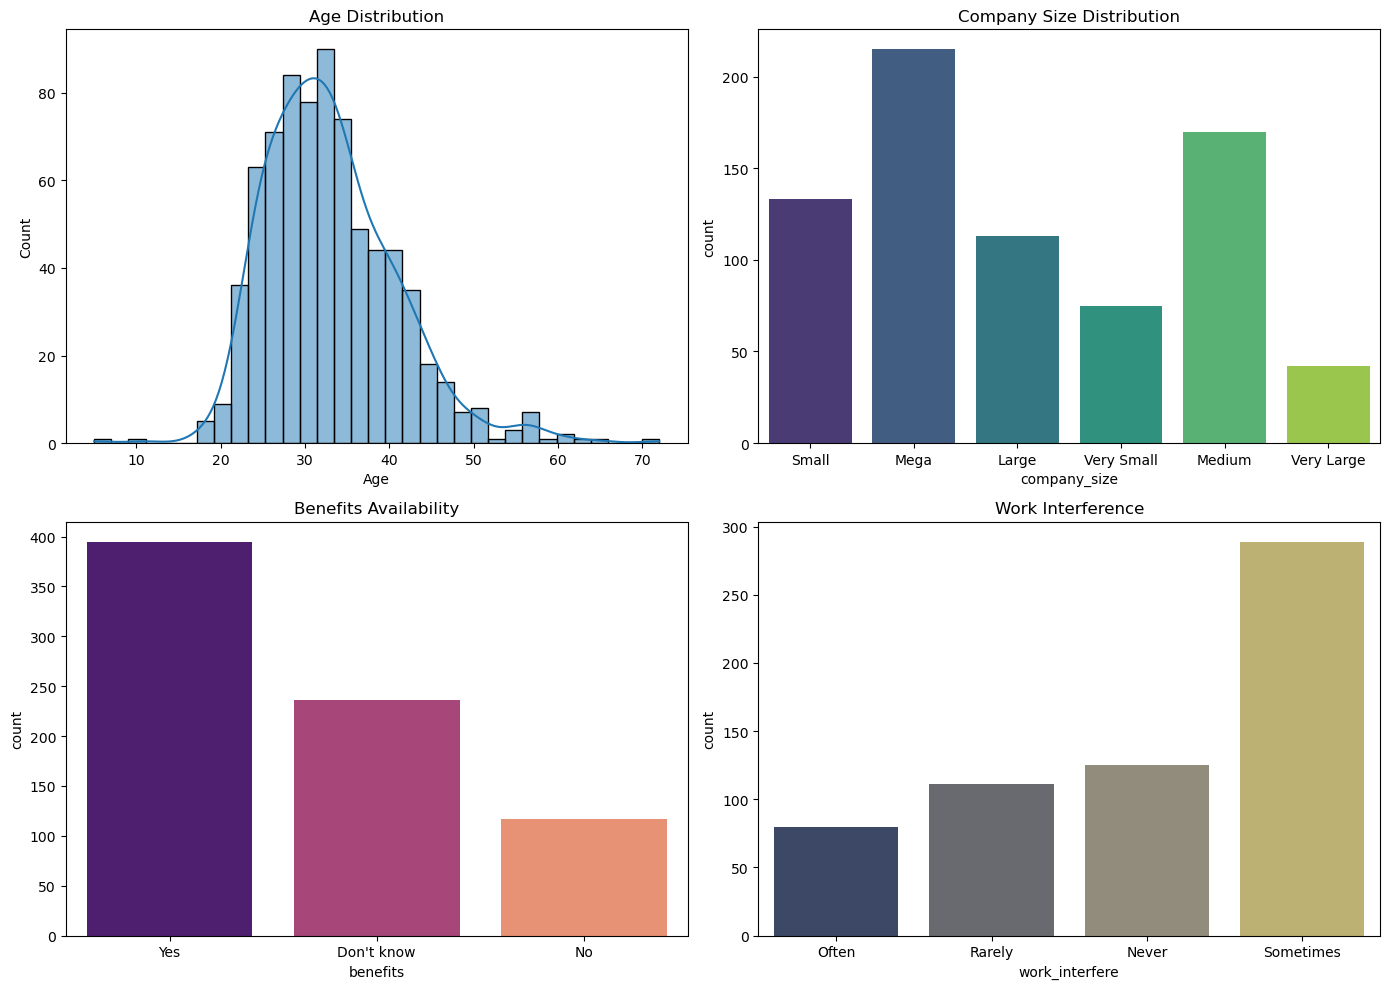

In [24]:
# General exploratory visualization
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plotting distributions of Age
sns.histplot(usa_data['Age'], kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Age Distribution')

# Plotting count of company sizes
sns.countplot(x='company_size', data=usa_data, ax=axs[0, 1], palette="viridis")
axs[0, 1].set_title('Company Size Distribution')

# Plotting count of benefits availability
sns.countplot(x='benefits', data=usa_data, ax=axs[1, 0], palette="magma")
axs[1, 0].set_title('Benefits Availability')

# Plotting count of work interference
sns.countplot(x='work_interfere', data=usa_data, ax=axs[1, 1], palette="cividis")
axs[1, 1].set_title('Work Interference')

# Adjusting layout
plt.tight_layout()

# Show plot
plt.show()

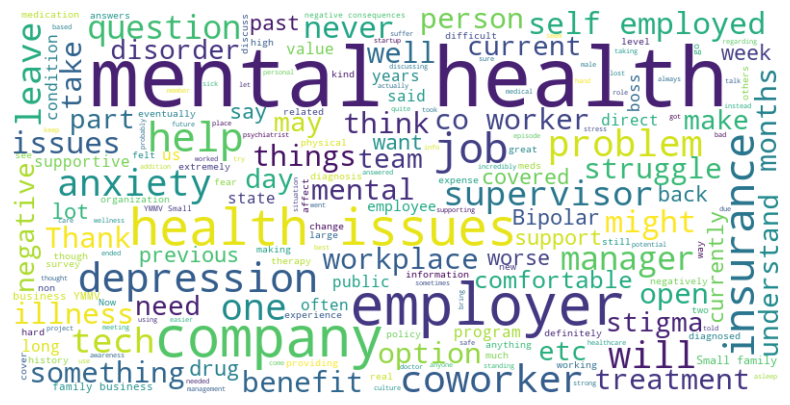

In [40]:
# Drop rows with None or NaN values in the comments column
usa_comments_df = usa_data.dropna(subset=['comments'])

# Define additional stopwords
custom_stopwords = set(STOPWORDS).union({
    'month', 'time', 'year', 'feel', 'issue', 'even', 'also', 
    'thing', 'really', 'many', 'work', 'better', 'know', 
    'people', 'seen', 'talking', 'overall', 'answer', 'reason'
})

# Combine all comments into a single string
text = " ".join(comment for comment in usa_comments_df.comments)

# Generate the word cloud
wordcloud = WordCloud(stopwords=custom_stopwords, background_color='white', width=800, height=400).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [46]:
# Filter the comments related to mental health subcategories
mental_health_comments_text = usa_data['comments'].dropna().str.lower()

# Combine all the comments into a single string
all_comments = ' '.join(mental_health_comments_text)

# Remove punctuation and split the text into words
words = re.findall(r'\b\w+\b', all_comments)

# Remove common stopwords (like 'the', 'and', etc.)
filtered_words = [word for word in words if word not in STOPWORDS]

# Define keywords and subcategories
tts_keywords = ['therapy', 'treatment', 'support']
mental_health_keywords = ['depression', 'anxiety', 'stress']

# Replace instances of 'therapy', 'treatment', and 'support' with 'tts'
filtered_words = ['tts' if word in tts_keywords else word for word in filtered_words]

# Combine mental health keywords with the new 'tts' category
mental_health_keywords.extend(['tts'])

# Filter the list of words to include only those related to mental health
associated_words = [word for word in filtered_words if word in mental_health_keywords]

# Count and print the occurrences of these mental health-related words
mental_health_word_counts = Counter(associated_words).most_common()

# Output the results
print(mental_health_word_counts)

[('tts', 16), ('depression', 13), ('anxiety', 11), ('stress', 3)]


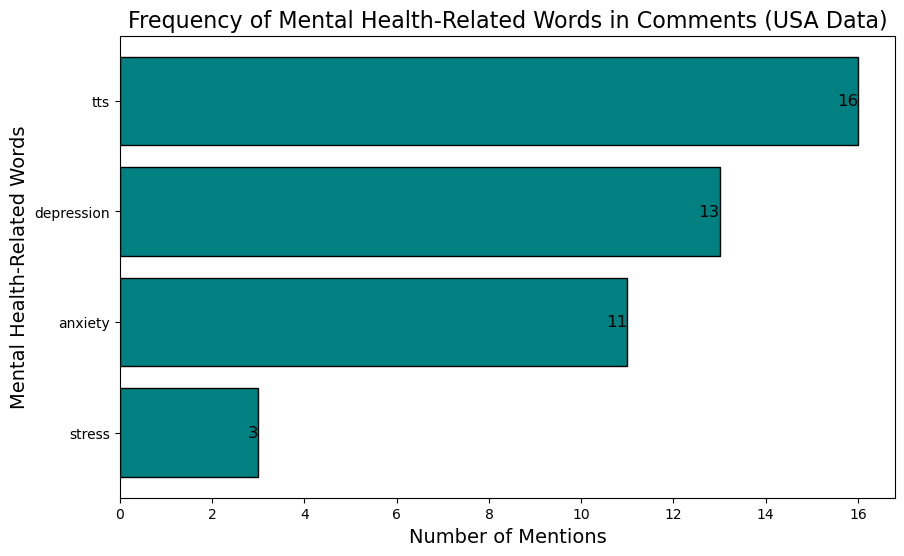

In [47]:
# Extract words and their counts for the bar chart
words, counts = zip(*mental_health_word_counts)

# Set up the figure
plt.figure(figsize=(10, 6))

# Plot the bar chart
plt.barh(words, counts, color='teal', edgecolor='black')

# Add titles and labels
plt.title('Frequency of Mental Health-Related Words in Comments (USA Data)', fontsize=16)
plt.xlabel('Number of Mentions', fontsize=14)
plt.ylabel('Mental Health-Related Words', fontsize=14)

# Add data labels
for index, value in enumerate(counts):
    plt.text(value, index, str(value), va='center', ha='right', fontsize=12, color='black')

# Invert y-axis to have the highest count on top
plt.gca().invert_yaxis()

# Show the plot
plt.show()

In [52]:
# Define the keywords for the subcategories related to mental health issues
keywords = {
    "tts": ["therapy", "treatment", "support"],
    "anxiety": ["anxiety"],
    "depression": ["depression"]
}

# Create a dictionary to store matching comments
us_theme_data = {key: {"count": 0, "comments": []} for key in keywords}

# Analyze US-specific comments
for comment in us_comments:
    comment_lower = comment.lower()
    for theme, terms in keywords.items():
        if any(term in comment_lower for term in terms):
            us_theme_data[theme]["count"] += 1
            us_theme_data[theme]["comments"].append(comment)

# Display the results for anxiety, depression, and tts
anxiety_comments = us_theme_data["anxiety"]["comments"]
depression_comments = us_theme_data["depression"]["comments"]
tts_comments = us_theme_data["tts"]["comments"]

# Print the number of comments and the comments themselves
print(f"Anxiety Comments ({len(anxiety_comments)} total):")
for comment in anxiety_comments[:5]:  # Displaying only first 5 for brevity
    print(comment)
    print("\n")

print(f"Depression Comments ({len(depression_comments)} total):")
for comment in depression_comments[:5]:  # Displaying only first 5 for brevity
    print(comment)
    print("\n")

print(f"TTS (Therapy, Treatment, Support) Comments ({len(tts_comments)} total):")
for comment in tts_comments[:5]:  # Displaying only first 5 for brevity
    print(comment)
    print("\n")

Anxiety Comments (8 total):
Family history of depression.  Currently dealing with depression and anxiety as well as drug addition.Employer provides & pays premiums on insurance which covers therapy and prescriptions.  Employer allows work-from-home and unlimited PTO which makes episodes easier to control.I don't speak of my problems to anyone at work except for the people that I consider friends and even then I don't go into great detail.I would never bring up a mental health issue during an interview for fear of discrimination and rejection (and therefore greater depression).  One co-worker had serious anxiety problems and would not inform his team of episodes and was eventually let go for being unresponsive.


The form of mental health problem that I suffer is anxiety.


I mostly suffer from social anxiety which keeps me from attending conferences. In my small dev group a big problem is a supervisor who's a workaholic and will never say no when asked to do something so he's doing the

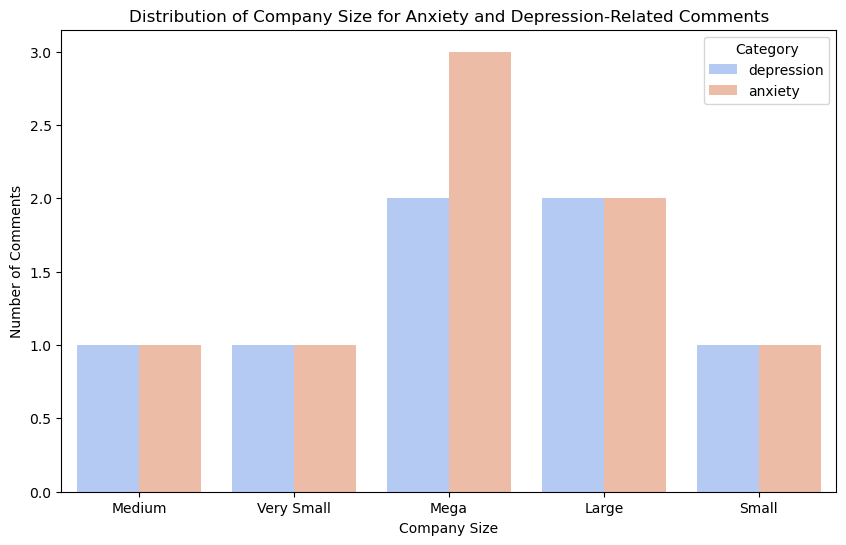

In [53]:
# Copy the relevant data
usa_data_viz = usa_data.copy()

# Create a new column to categorize comments
usa_data_viz['category'] = usa_data_viz.apply(
    lambda row: 'anxiety' if pd.notna(row['comments']) and any(term in row['comments'].lower() for term in keywords['anxiety']) else
                'depression' if pd.notna(row['comments']) and any(term in row['comments'].lower() for term in keywords['depression']) else
                'none', axis=1
)

# Filter out rows without anxiety or depression
usa_data_viz_filtered = usa_data_viz[usa_data_viz['category'] != 'none']

# Plot a stacked bar chart for the 'company_size' factor
plt.figure(figsize=(10, 6))
sns.countplot(data=usa_data_viz_filtered, x='company_size', hue='category', palette='coolwarm')
plt.title('Distribution of Company Size for Anxiety and Depression-Related Comments')
plt.xlabel('Company Size')
plt.ylabel('Number of Comments')
plt.legend(title='Category')
plt.show()

In [ ]:
# create another word cloud for only mega company (whatever we want to explore)

In [ ]:
# create a sentiment analysis for the comments in the mega company 

In [ ]:
## print out some of the comments from workers who work in that company 

In [ ]:
## combine leave/support as one column and see how that influences people who work for mega corps

In [ ]:
## end with Sams story how she changed companys that value her mental health 

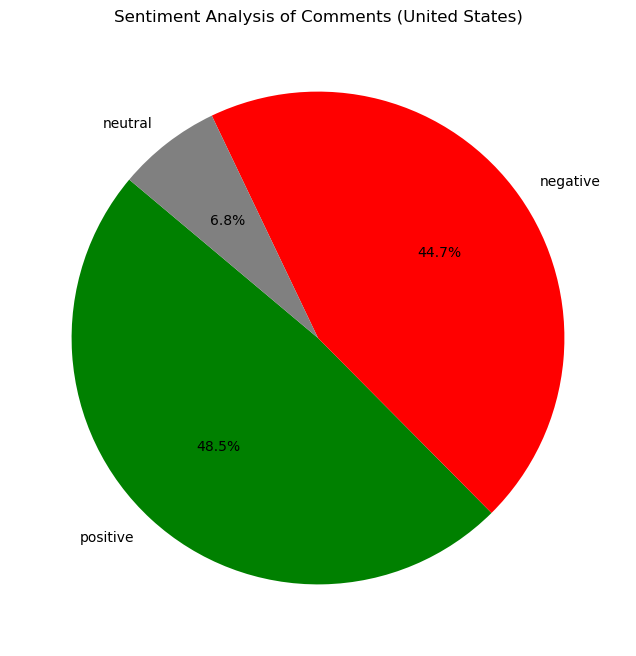

In [26]:
# Extract the comments column and drop any missing values
comments = usa_data['comments'].dropna()

# Perform sentiment analysis on the comments
comments_sentiment = comments.apply(lambda x: TextBlob(x).sentiment.polarity)

# Adding sentiment scores back to the dataset
usa_data['comment_sentiment'] = comments_sentiment

# Count of comments with positive, negative, and neutral sentiment
sentiment_distribution = comments_sentiment.apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral')).value_counts()

# Close the database connection
conn.close()

# Creating a pie chart to visualize the sentiment distribution
plt.figure(figsize=(8, 8))
plt.pie(sentiment_distribution.values, labels=sentiment_distribution.index, autopct='%1.1f%%',
        colors=['green', 'red', 'gray'], startangle=140)
plt.title('Sentiment Analysis of Comments (United States)')
plt.show()

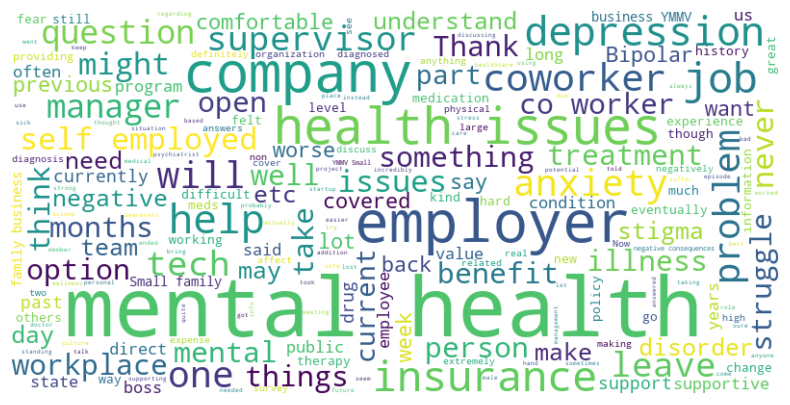

In [39]:
# Drop rows with None or NaN values in the comments column
usa_comments_df = usa_data.dropna(subset=['comments'])

# Define additional stopwords
custom_stopwords = set(STOPWORDS).union({
    'month', 'time', 'year', 'feel', 'issue', 'even', 'also', 
    'thing', 'really', 'many', 'work', 'better', 'know', 
    'people', 'seen', 'talking', 'overall', 'answer', 'reason'
})

# Combine all comments into a single string
text = " ".join(comment for comment in usa_comments_df.comments)

# Generate the word cloud
wordcloud = WordCloud(stopwords=custom_stopwords, background_color='white', width=800, height=400).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [28]:
# Filter the comments related to mental health subcategories
mental_health_comments_text = usa_data['comments'].dropna().str.lower()

# Combine all the comments into a single string
all_comments = ' '.join(mental_health_comments_text)

# Remove punctuation and split the text into words
words = re.findall(r'\b\w+\b', all_comments)

# Remove common stopwords (like 'the', 'and', etc.)
filtered_words = [word for word in words if word not in STOPWORDS]

# Focus on words specifically associated with mental health issues
mental_health_keywords = ['depression', 'anxiety', 'stress', 'treatment', 'therapy', 'support', 'burnout']

# Filter the list of words to include only those related to mental health
associated_words = [word for word in filtered_words if word in mental_health_keywords]

# Count and print the occurrences of these mental health-related words
mental_health_word_counts = Counter(associated_words).most_common()

# Output the results
print(mental_health_word_counts)

[('depression', 13), ('anxiety', 11), ('treatment', 7), ('support', 5), ('therapy', 4), ('stress', 3), ('burnout', 1)]


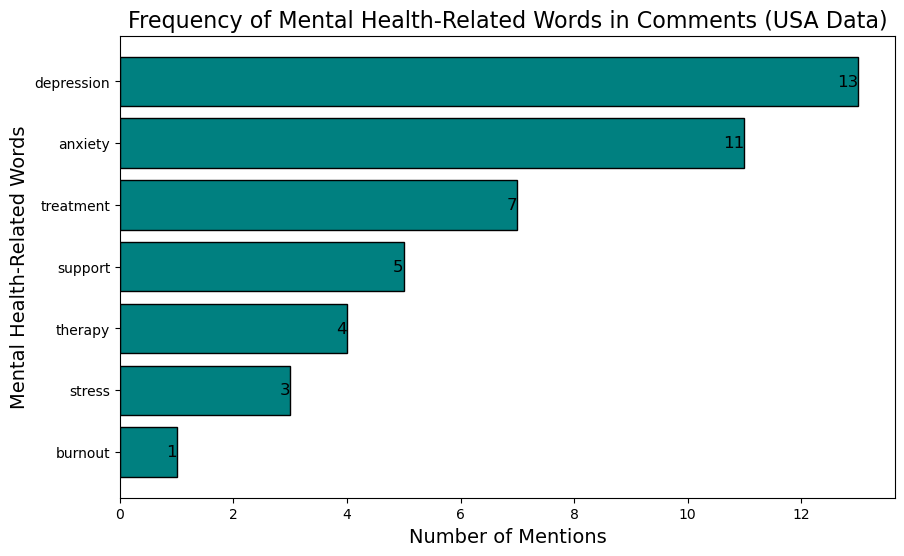

In [29]:

# Extract words and their counts for the bar chart
words, counts = zip(*mental_health_word_counts)

# Set up the figure
plt.figure(figsize=(10, 6))

# Plot the bar chart
plt.barh(words, counts, color='teal', edgecolor='black')

# Add titles and labels
plt.title('Frequency of Mental Health-Related Words in Comments (USA Data)', fontsize=16)
plt.xlabel('Number of Mentions', fontsize=14)
plt.ylabel('Mental Health-Related Words', fontsize=14)

# Add data labels
for index, value in enumerate(counts):
    plt.text(value, index, str(value), va='center', ha='right', fontsize=12, color='black')

# Invert y-axis to have the highest count on top
plt.gca().invert_yaxis()

# Show the plot
plt.show()

In [30]:
# Filter the data for respondents from the United States
us_comments = usa_data['comments'].dropna()

# Define the keywords for the subcategories related to mental health issues
keywords = {
    "anxiety": ["anxiety"],
    "depression": ["depression"]
}

# Create a dictionary to store matching comments
us_theme_data = {key: {"count": 0, "comments": []} for key in keywords}

# Analyze US-specific comments
for comment in us_comments:
    comment_lower = comment.lower()
    for theme, terms in keywords.items():
        if any(term in comment_lower for term in terms):
            us_theme_data[theme]["count"] += 1
            us_theme_data[theme]["comments"].append(comment)

# Display the results for anxiety and depression
anxiety_comments = us_theme_data["anxiety"]["comments"]
depression_comments = us_theme_data["depression"]["comments"]

# Print the number of comments and the comments themselves
print(f"Anxiety Comments ({len(anxiety_comments)} total):")
for comment in anxiety_comments[:5]:  # Displaying only first 5 for brevity
    print(comment)
    print("\n")

print(f"Depression Comments ({len(depression_comments)} total):")
for comment in depression_comments[:5]:  # Displaying only first 5 for brevity
    print(comment)
    print("\n")

Anxiety Comments (8 total):
Family history of depression.  Currently dealing with depression and anxiety as well as drug addition.Employer provides & pays premiums on insurance which covers therapy and prescriptions.  Employer allows work-from-home and unlimited PTO which makes episodes easier to control.I don't speak of my problems to anyone at work except for the people that I consider friends and even then I don't go into great detail.I would never bring up a mental health issue during an interview for fear of discrimination and rejection (and therefore greater depression).  One co-worker had serious anxiety problems and would not inform his team of episodes and was eventually let go for being unresponsive.


The form of mental health problem that I suffer is anxiety.


I mostly suffer from social anxiety which keeps me from attending conferences. In my small dev group a big problem is a supervisor who's a workaholic and will never say no when asked to do something so he's doing the

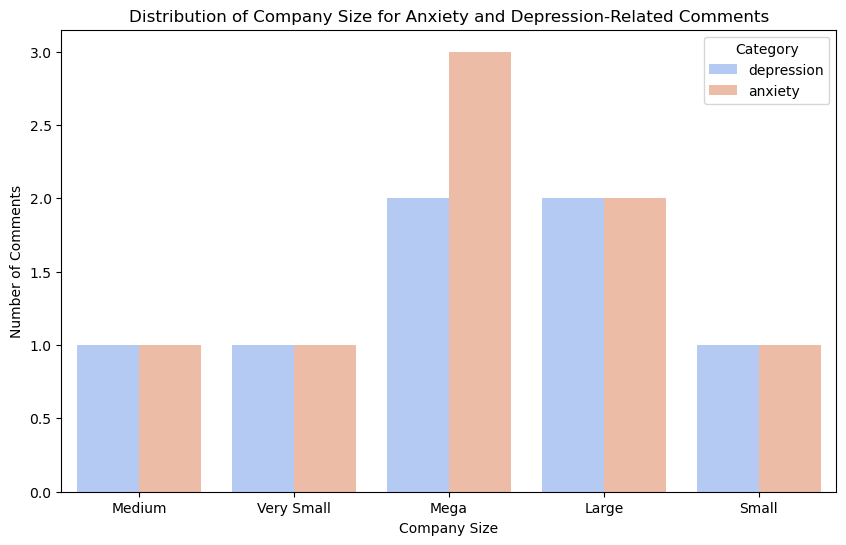

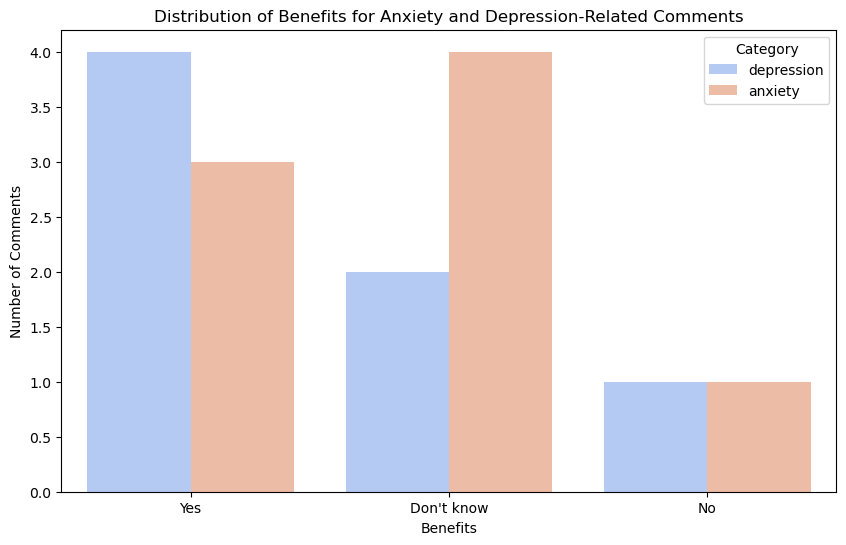

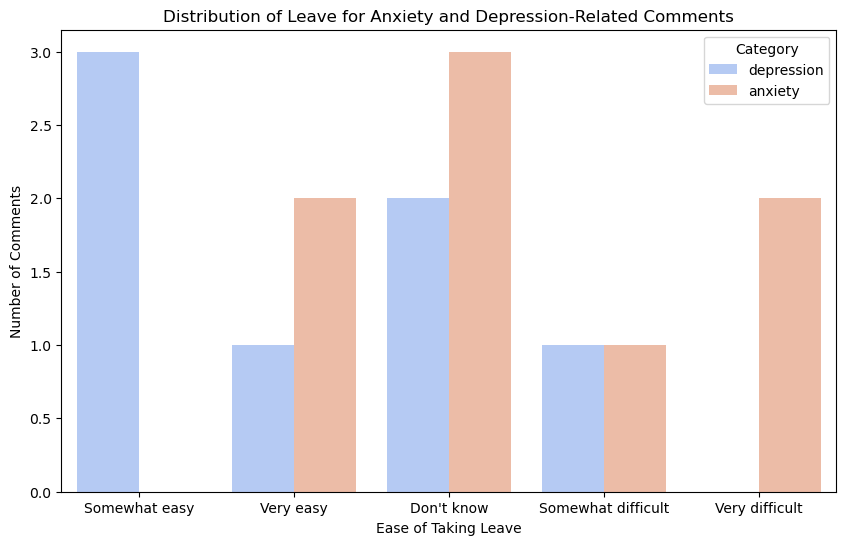

In [31]:
# Copy the relevant data
usa_data_viz = usa_data.copy()

# Create a new column to categorize comments
usa_data_viz['category'] = usa_data_viz.apply(
    lambda row: 'anxiety' if pd.notna(row['comments']) and any(term in row['comments'].lower() for term in keywords['anxiety']) else
                'depression' if pd.notna(row['comments']) and any(term in row['comments'].lower() for term in keywords['depression']) else
                'none', axis=1
)

# Filter out rows without anxiety or depression
usa_data_viz_filtered = usa_data_viz[usa_data_viz['category'] != 'none']

# Plot a stacked bar chart for the 'company_size' factor
plt.figure(figsize=(10, 6))
sns.countplot(data=usa_data_viz_filtered, x='company_size', hue='category', palette='coolwarm')
plt.title('Distribution of Company Size for Anxiety and Depression-Related Comments')
plt.xlabel('Company Size')
plt.ylabel('Number of Comments')
plt.legend(title='Category')
plt.show()

# Plot a stacked bar chart for the 'benefits' factor
plt.figure(figsize=(10, 6))
sns.countplot(data=usa_data_viz_filtered, x='benefits', hue='category', palette='coolwarm')
plt.title('Distribution of Benefits for Anxiety and Depression-Related Comments')
plt.xlabel('Benefits')
plt.ylabel('Number of Comments')
plt.legend(title='Category')
plt.show()

# Plot a stacked bar chart for the 'leave' factor
plt.figure(figsize=(10, 6))
sns.countplot(data=usa_data_viz_filtered, x='leave', hue='category', palette='coolwarm')
plt.title('Distribution of Leave for Anxiety and Depression-Related Comments')
plt.xlabel('Ease of Taking Leave')
plt.ylabel('Number of Comments')
plt.legend(title='Category')
plt.show()